# Parameterized level set optimization of a y-branch

**Note: the cost of running the entire notebook is higher than 1 FlexCredit.**

This notebook demonstrates how to set up and run a simple parameterized level set-based optimization of a Y-branch. In this approach, we use `jax` to generate a level set surface $\phi(\rho)$ given a set of design parameters $\rho$. The permittivity distribution is then obtained from the zero level set isocontour. Details about the level set method can be found [here](<https://doi.org/10.1016/S0045-7825(02)00559-5>). In addition, we show how to tailor the initial level set function to a starting geometry, which is helpful to further optimize a device obtained by conventional design. You can also find some interesting adjoint functionalities for shape optimization in [Inverse design optimization of a waveguide taper](../notebooks/AdjointPlugin5BoundaryGradients.html) and [Adjoint-based shape optimization of a waveguide bend](../notebooks/AdjointPlugin8WaveguideBend.html).

<img src="img/y_branch_level_set.png" alt="Y-branch Level Set Structure"  width="600"/>

Let's start by importing the Python libraries used throughout this notebook.

In [1]:
# Standard python imports.
from typing import List
import numpy as np
import matplotlib.pylab as plt

# Import jax to be able to use automatic differentiation.
import jax.numpy as jnp
from jax import value_and_grad
import optax

# Import regular tidy3d.
import tidy3d as td
import tidy3d.web as web

# Import the components we need from the adjoint plugin.
import tidy3d.plugins.adjoint as tda
from tidy3d.plugins.adjoint.web import run

## Y-branch Inverse Design Configuration

The y-branch splits the power from an input waveguide into two other output waveguides. Here, we are considering a gap of 0.3 $\mu m$ between the output waveguides for illustration purposes. However, when considering the design of a practical device, this value can be smaller and s-bends can be added to the outputs. This can increase the computation time slightly but potentially generate better results.

Next, you can set the y-branch geometry and the inverse design parameters.

In [2]:
# Geometric parameters.
y_width = 1.7  # Y-branch maximum width (um).
y_length = 1.5  # Y-branch maximum length (um).
w_thick = 0.22  # Waveguide thickness (um).
w_width = 0.5  # Waveguide width (um).
w_length = 1.0  # Input output waveguide length (um).
w_gap = 0.3  # Gap between the output waveguides (um).

# Material.
nSi = 3.48  # Silicon refractive index.

# Inverse design set up parameters.
grid_size = 0.02  # Simulation grid size on design region (um).
ls_grid_size = 0.005  # Discretization size of the level set function (um).
ls_down_sample = 20  # The spacing between the level set control knots is given by ls_grid_size*ls_down_sample.
fom_name_1 = "fom_field1"  # Name of the monitor used to compute the objective function.
fom_name_2 = "fom_field2"  # Name of the monitor used to compute the objective function.

# Optimizer parameters.
iterations = 50  # Maximum number of iterations in optimization.
learning_rate = 3e-2

# Simulation wavelength.
wl = 1.55  # Central simulation wavelength (um).
bw = 0.06  # Simulation bandwidth (um).
n_wl = 61  # Number of wavelength points within the bandwidth.

From the parameters defined before, a lot of variables are computed and used to set up the optimization.

In [3]:
# Minimum and maximum values for the permittivities.
eps_max = nSi ** 2
eps_min = 1.0

# Material definition.
mat_si = td.Medium(permittivity=eps_max)  # Waveguide material.

# Wavelengths and frequencies.
wl_max = wl + bw / 2
wl_min = wl - bw / 2
wl_range = np.linspace(wl_min, wl_max, n_wl)
freq = td.C_0 / wl
freqs = td.C_0 / wl_range
freqw = 0.5 * (freqs[0] - freqs[-1])
run_time = 1e-12

# Computational domain size.
pml_spacing = 0.6 * wl
size_x = 2 * w_length + y_length
size_y = y_width + 2 * pml_spacing
size_z = w_thick + 2 * pml_spacing
eff_inf = 10

# Source and monitor positions.
mon_w = w_width + 1.9 * w_gap
mon_h = 5 * w_thick

# Separation between the level set control knots.
rho_size = ls_down_sample * ls_grid_size

# Number of points on the parameter grid (rho) and level set grid (phi)
nx_rho = int(y_length / rho_size) + 1
ny_rho = int(y_width / rho_size / 2.0) + 1
nx_phi = int(y_length / ls_grid_size) + 1
ny_phi = int(y_width / ls_grid_size) + 1
npar = nx_rho * ny_rho

# Design region size
dr_size_x = (nx_phi - 1) * ls_grid_size
dr_size_y = (ny_phi - 1) * ls_grid_size
dr_center_x = -size_x / 2 + w_length + dr_size_x / 2

# xy coordinates of the parameter and level set grids.
x_rho = np.linspace(dr_center_x - dr_size_x / 2, dr_center_x + dr_size_x / 2, nx_rho)
x_phi = np.linspace(dr_center_x - dr_size_x / 2, dr_center_x + dr_size_x / 2, nx_phi)
y_rho = np.linspace(-dr_size_y / 2, dr_size_y / 2, ny_rho)
y_phi = np.linspace(-dr_size_y / 2, dr_size_y / 2, ny_phi)

## Level Set Functions
We are using `jax` to implement a parameterized level set function so the gradients can be back-propagated from the permittivity distribution defined by the zero level set isocontour to the design variables (the control knots of the level set surface). The space between the control knots and the Gaussian function width obtains some control over the minimum feature size. Other types of radial basis functions can also be used in replacement of the Gaussian one employed here, such as [multiquadric splines](<https://onlinelibrary.wiley.com/doi/10.1002/nme.1536>) or [b-splines](<https://opg.optica.org/oe/fulltext.cfm?uri=oe-28-5-7060&id=427821>).

In [4]:
class LevelSetInterp(object):
    """This class implements the level set surface using Gaussian radial basis functions."""

    def __init__(
        self,
        x0: np.ndarray = None,
        y0: np.ndarray = None,
        z0: np.ndarray = None,
        sigma: float = None,
    ):
        # Input data.
        x, y = np.meshgrid(y0, x0)
        xy0 = np.column_stack((x.reshape(-1), y.reshape(-1)))
        self.xy0 = xy0
        self.z0 = z0
        self.sig = sigma
        # Builds the level set interpolation model.
        gauss_kernel = self.gaussian(self.xy0, self.xy0)
        self.model = jnp.dot(jnp.linalg.inv(gauss_kernel), self.z0)

    def gaussian(self, xyi, xyj):
        dist = np.sqrt(
            (xyi[:, 1].reshape(-1, 1) - xyj[:, 1].reshape(1, -1)) ** 2
            + (xyi[:, 0].reshape(-1, 1) - xyj[:, 0].reshape(1, -1)) ** 2
        )
        return np.exp(-(dist ** 2) / (2 * self.sig ** 2))

    def get_ls(self, x1, y1):
        xx, yy = np.meshgrid(y1, x1)
        xy1 = np.column_stack((xx.reshape(-1), yy.reshape(-1)))
        return self.gaussian(self.xy0, xy1).T @ self.model


# Function to plot the level set surface.
def plot_level_set(x0, y0, rho, x1, y1, phi):
    y, x = np.meshgrid(y0, x0)
    yy, xx = np.meshgrid(y1, x1)
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={"projection": "3d"})
    surf = ax1.plot_surface(xx, yy, phi, cmap="RdBu", alpha=0.5)
    ax1.contour3D(xx, yy, phi, 1, cmap="binary")
    ax1.scatter(x, y, rho, color="black", linewidth=1.0)
    ax1.set_title("$\Phi(\\rho)$")
    ax1.set_xlabel("x ($\mu m$)")
    ax1.set_ylabel("y ($\mu m$)")
    fig.colorbar(surf, ax=ax1, shrink=0.3)
    plt.tight_layout()
    plt.show()

To map the permittivities to the zero-level set contour and obtain continuous derivatives, we use a hyperbolic tangent function as an approximation to a Heaviside function. Other smooth functions, such as sigmoid and arctangent, can also be employed. As discussed [here](https://www.sciencedirect.com/science/article/pii/S0009250917303986), the difference on computed interface using different functions will decrease when reducing the mesh size.

In [5]:
def get_eps(design_param, plot_levelset=False) -> np.ndarray:
    """Returns the permittivities defined by the zero level set isocontour"""

    phi_model = LevelSetInterp(x0=x_rho, y0=y_rho, z0=design_param, sigma=rho_size)
    phi = phi_model.get_ls(x1=x_phi, y1=y_phi)

    # Calculates the permittivities from the level set surface.
    sharpness = 10
    eps_phi = 0.5 * (jnp.tanh(sharpness * phi) + 1.0001)
    eps = eps_min + (eps_max - eps_min) * eps_phi

    # Reshapes the design parameters into a 2D matrix.
    eps = jnp.reshape(eps, (nx_phi, ny_phi))

    # Plots the level set surface.
    if plot_levelset:
        rho = np.reshape(design_param, (nx_rho, ny_rho))
        phi = np.reshape(phi, (nx_phi, ny_phi))
        plot_level_set(x0=x_rho, y0=y_rho, rho=rho, x1=x_phi, y1=y_phi, phi=phi)

    return eps

In the next function, the permittivity values are used to build a [JaxCustomMedium](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.adjoint.JaxCustomMedium.html) within the design region.

In [6]:
def update_design(eps) -> List[tda.JaxStructure]:
    # Reflects the structure about the x-axis.
    eps_val = jnp.array(eps).reshape((nx_phi, ny_phi, 1, 1))

    # Definition of the coordinates x,y along the design region.
    coords_x = [
        (dr_center_x - dr_size_x / 2) + ix * ls_grid_size for ix in range(nx_phi)
    ]
    coords_y = [-dr_size_y / 2 + iy * ls_grid_size for iy in range(ny_phi)]
    coords = dict(x=coords_x, y=coords_y, z=[0], f=[freq])

    # Creation of a custom medium using the values of the design parameters.
    eps_components = {
        f"eps_{dim}{dim}": tda.JaxDataArray(values=eps_val, coords=coords) for dim in "xyz"
    }
    eps_dataset = tda.JaxPermittivityDataset(**eps_components)
    eps_medium = tda.JaxCustomMedium(eps_dataset=eps_dataset)
    box = tda.JaxBox(center=(dr_center_x, 0, 0), size=(dr_size_x, dr_size_y, w_thick))
    design_structure = tda.JaxStructure(geometry=box, medium=eps_medium)
    return [design_structure]

## Initial Structure

The initial y-brach structure is a simple polygon connecting the input and output waveguides. We define this structure using a `PolySlab` object and then translate it into a permittivity grid of the same size as the one used to define the level set function.

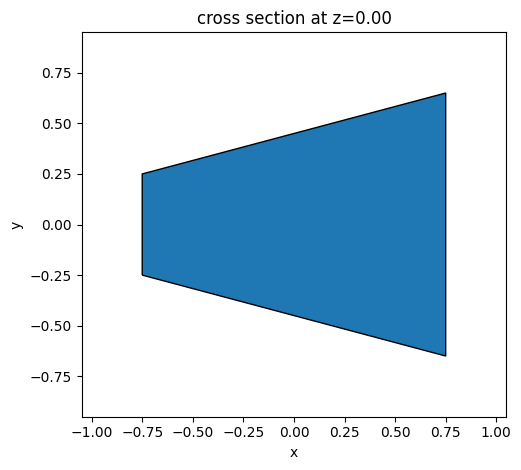

In [30]:
vertices = np.array(
    [
        (-size_x / 2 + w_length, w_width / 2),
        (-size_x / 2 + w_length + dr_size_x, w_gap / 2 + w_width),
        (-size_x / 2 + w_length + dr_size_x, -w_gap / 2 - w_width),
        (-size_x / 2 + w_length, -w_width / 2),
    ]
)

init_design = td.PolySlab(
    vertices=vertices, axis=2, slab_bounds=(-w_thick / 2, w_thick / 2)
)
init_eps = init_design.inside_meshgrid(x=x_phi, y=y_phi, z=np.zeros((1)))
init_eps = np.squeeze(init_eps) * eps_max
init_design.plot(z=0)
plt.show()

Then an objective function which compares the initial structure and the permittivity distribution generated by the level set zero contour is defined. 

In [8]:
# Figure of Merit (FOM) calculation.
def fom_eps(eps_ref: np.ndarray, eps: np.ndarray) -> float:
    """Calculate the L2 norm between eps_ref and eps."""
    return jnp.mean(jnp.abs(eps_ref - eps) ** 2)

# Objective function to be passed to the optimization algorithm.
def obj_eps(design_param, eps_ref) -> float:
    eps = get_eps(design_param)
    return fom_eps(eps_ref, eps)

# Function to calculate the objective function value and its
# gradient with respect to the design parameters.
obj_grad_eps = value_and_grad(obj_eps)

So, the initial design parameters are obtained after fitting the initial structure using the level set function. This is accomplished by minimizing the L2 norm between the reference and the level set generated permittivities. The fitting is performed by the Adam optimizer from the [Optax](https://optax.readthedocs.io/en/latest/index.html) library. 

In [9]:
# Initialize adam optimizer with starting parameters.
start_par = np.zeros((npar))
optimizer = optax.adam(learning_rate=learning_rate*10)
opt_state = optimizer.init(start_par)

# Store history
params_eps = start_par
obj_eps = []
params_history_eps = [start_par]

for i in range(iterations):

    # Compute gradient and current objective funciton value.
    value, gradient = obj_grad_eps(params_eps, init_eps)

    # outputs
    print(f"Step = {i + 1}")
    print(f"\tobj_eps = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

    # Compute and apply updates to the optimizer based on gradient.
    updates, opt_state = optimizer.update(gradient, opt_state, params_eps)
    params_eps = optax.apply_updates(params_eps, updates)

    # Save history.
    obj_eps.append(value)
    params_history_eps.append(params_eps)

# Gets the final parameters and the objective values history.
init_rho = params_history_eps[-1]
obj_vals_eps = np.array(obj_eps)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Step = 1
	obj_eps = 3.6577e+01
	grad_norm = 5.2321e+01
Step = 2
	obj_eps = 6.8107e+00
	grad_norm = 4.8000e+00
Step = 3
	obj_eps = 5.3584e+00
	grad_norm = 3.5517e+00
Step = 4
	obj_eps = 4.0776e+00
	grad_norm = 3.0787e+00
Step = 5
	obj_eps = 3.1785e+00
	grad_norm = 2.8593e+00
Step = 6
	obj_eps = 2.4227e+00
	grad_norm = 2.2196e+00
Step = 7
	obj_eps = 2.2520e+00
	grad_norm = 2.4428e+00
Step = 8
	obj_eps = 2.0383e+00
	grad_norm = 2.4812e+00
Step = 9
	obj_eps = 1.6428e+00
	grad_norm = 2.2070e+00
Step = 10
	obj_eps = 1.3223e+00
	grad_norm = 1.8035e+00
Step = 11
	obj_eps = 1.2391e+00
	grad_norm = 1.4184e+00
Step = 12
	obj_eps = 1.4014e+00
	grad_norm = 1.7733e+00
Step = 13
	obj_eps = 1.4985e+00
	grad_norm = 1.8336e+00
Step = 14
	obj_eps = 1.4508e+00
	grad_norm = 1.7757e+00
Step = 15
	obj_eps = 1.2780e+00
	grad_norm = 1.5841e+00
Step = 16
	obj_eps = 1.0781e+00
	grad_norm = 1.2339e+00
Step = 17
	obj_eps = 9.8677e-01
	grad_norm = 1.0177e+00
Step = 18
	obj_eps = 1.0221e+00
	grad_norm = 1.1454e+00
S

The following graph shows the evolution of the objective function along the fitting.

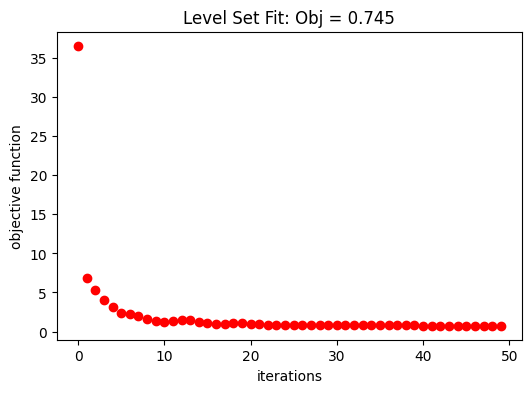

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(obj_vals_eps, "ro")
ax.set_xlabel("iterations")
ax.set_ylabel("objective function")
ax.set_title(f"Level Set Fit: Obj = {obj_vals_eps[-1]:.3f}")
plt.show()

Here, one can see the initial parameters, which are the control knots that define the level set surface. The geometry of the structure will change as the zero isocontour evolves.

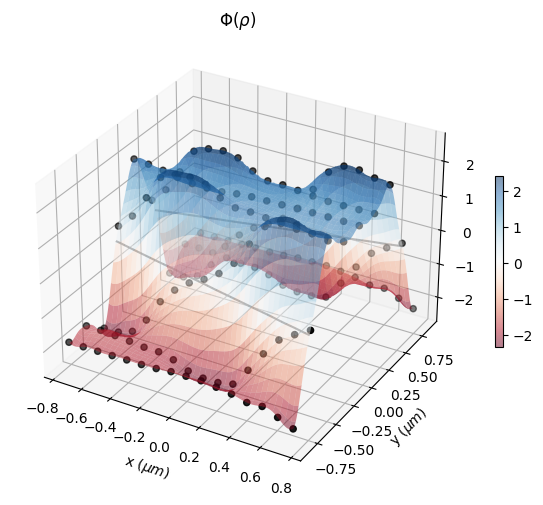

In [11]:
eps_fit = get_eps(init_rho, plot_levelset=True)

## Inverse Design Optimization Set Up

Next, we will write a function to return the `JaxSimulation` object. Note that we are using a `MeshOverrideStructure` to obtain a uniform mesh over the design region.

The elements that do not change along the optimization are defined first.

In [12]:
# Input waveguide.
wg_input = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-eff_inf, -w_width / 2, -w_thick / 2),
        rmax=(-size_x / 2 + w_length, w_width / 2, w_thick / 2),
    ),
    medium=mat_si,
)

# Output waveguide 1.
wg_output_1 = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-size_x / 2 + w_length + dr_size_x, w_gap / 2, -w_thick / 2),
        rmax=(size_x / 2 + eff_inf, w_gap / 2 + w_width, w_thick / 2),
    ),
    medium=mat_si,
)

# Output waveguide 2.
wg_output_2 = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-size_x / 2 + w_length + dr_size_x, -w_gap / 2 - w_width, -w_thick / 2),
        rmax=(size_x / 2 + eff_inf, -w_gap / 2, w_thick / 2),
    ),
    medium=mat_si,
)

# Input mode source.
mode_spec = td.ModeSpec(num_modes=1, target_neff=nSi)
source = td.ModeSource(
    center=(-size_x / 2 + 0.25 * wl, 0, 0),
    size=(0, mon_w, mon_h),
    source_time=td.GaussianPulse(freq0=freq, fwidth=freqw),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# Monitor where we will compute the objective function from.
fom_monitor_1 = td.ModeMonitor(
    center=[size_x / 2 - 0.25 * wl, w_gap / 2 + w_width / 2, 0],
    size=[0, mon_w, mon_h],
    freqs=[freq],
    mode_spec=mode_spec,
    name=fom_name_1,
)

# Monitor where we will compute the objective function from.
fom_monitor_2 = td.ModeMonitor(
    center=[size_x / 2 - 0.25 * wl, -w_gap / 2 - w_width / 2, 0],
    size=[0, mon_w, mon_h],
    freqs=[freq],
    mode_spec=mode_spec,
    name=fom_name_2,
)

### Monitors used only to visualize the initial and final y-branch results.
# Field monitors to visualize the final fields.
field_xy = td.FieldMonitor(
    size=(td.inf, td.inf, 0),
    freqs=[freq],
    name="field_xy",
)

# Monitor where we will compute the objective function from.
fom_final_1 = td.ModeMonitor(
    center=[size_x / 2 - 0.25 * wl, w_gap / 2 + w_width / 2, 0],
    size=[0, mon_w, mon_h],
    freqs=freqs,
    mode_spec=mode_spec,
    name="out_1",
)

# Monitor where we will compute the objective function from.
fom_final_2 = td.ModeMonitor(
    center=[size_x / 2 - 0.25 * wl, -w_gap / 2 - w_width / 2, 0],
    size=[0, mon_w, mon_h],
    freqs=freqs,
    mode_spec=mode_spec,
    name="out_2",
)

[21:45:13] WARNING: Default value for the field monitor           ]8;id=924173;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=186538;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

And then the `JaxSimulation` is built using the design parameters.

In [13]:
def make_adjoint_sim(design_param) -> tda.JaxSimulation:
    # Builds the design region from the design parameters.
    eps = get_eps(design_param)
    design_structure = update_design(eps)

    # Creates a uniform mesh for the design region.
    adjoint_dr_mesh = td.MeshOverrideStructure(
        geometry=td.Box(
            center=(dr_center_x, 0, 0), size=(dr_size_x, dr_size_y, w_thick)
        ),
        dl=[grid_size, grid_size, grid_size],
        enforce=True,
    )

    return tda.JaxSimulation(
        size=[size_x, size_y, size_z],
        center=[0, 0, 0],
        grid_spec=td.GridSpec.auto(
            wavelength=wl_max,
            min_steps_per_wvl=15,
            override_structures=[adjoint_dr_mesh],
        ),
        symmetry=(0, 0, 1),
        structures=[wg_input, wg_output_1, wg_output_2],
        input_structures=design_structure,
        sources=[source],
        monitors=[],
        output_monitors=[fom_monitor_1, fom_monitor_2],
        run_time=run_time,
        subpixel=True,
    )

Let's visualize the simulation set up and verify if all the elements are in their correct places. One can see that we start from a fully binarized structure.

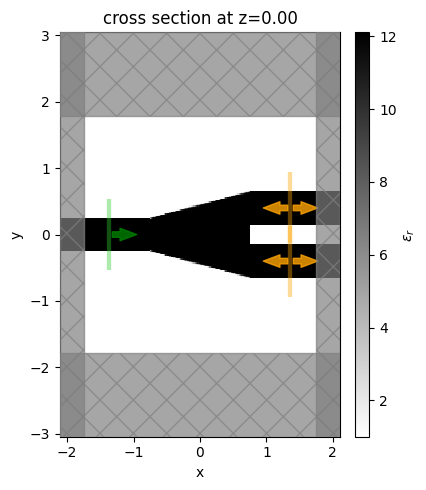

In [14]:
init_design = make_adjoint_sim(init_rho)

fig, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(5, 5))
init_design.plot_eps(z=0, ax=ax1)
plt.show()

Now, we run this simulation and see how this non-optimized y-branch performs.

In [15]:
sim_init = init_design.to_simulation()[0].copy(
    update=dict(monitors=(field_xy, fom_final_1, fom_final_2))
)
sim_data = web.run(sim_init, task_name="initial y-branch")

[21:45:15] Created task 'initial y-branch' with task_id            ]8;id=715414;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=655963;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-a6005da3-4b4b-481a-bd39-756d6ee9aef9v1'.                       

           View task using web UI at                               ]8;id=344119;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=64983;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=265594;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6005da3-4b4b-481a-bd39-756d6ee9aef9v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=910754;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6005da3-4b4b-481a-bd39-756d6ee9aef9v1\taskId]8;;\]8;id=265594;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6005da3-4b4b-481a-bd39-756d6ee9aef9v1\=]8;;\]8;id=537667;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6005da3-4b4b-481a-bd39-756d6ee9aef9v1\fdve]8;;\]8;id=265594;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6005da3-4b4b-481a-bd39-756d6ee9aef9v1\-]8;;\              
           ]8;id=265594;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6005da3-4b4b-481a-bd39-756d6ee9aef9v1\a6005da3-4b4b-481a-bd39-756d6ee9aef9v1']8;;\.                             

Output()

[21:45:24] status = queued                                         ]8;id=624469;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=826450;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#361\361]8;;\

Output()

[21:45:29] status = preprocess                                     ]8;id=832986;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=158731;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#355\355]8;;\

[21:45:35] Maximum FlexCredit cost: 0.025. Use                     ]8;id=249390;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=620291;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=715858;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=964529;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#377\377]8;;\

           running solver                                          ]8;id=755277;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=743166;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=494378;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=986885;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[21:45:51] early shutoff detected, exiting.                        ]8;id=169889;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=308890;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#404\404]8;;\

           status = postprocess                                    ]8;id=748141;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=744914;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#420\420]8;;\

Output()

[21:45:57] status = success                                        ]8;id=479525;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=192411;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#427\427]8;;\

Output()

[21:46:03] loading SimulationData from simulation_data.hdf5        ]8;id=954616;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=438185;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#591\591]8;;\

The coupling efficiencies of the non-optimized y-branch outputs are around -6 dB at 1.55 $\mu m$, and much of the input power is reflected.

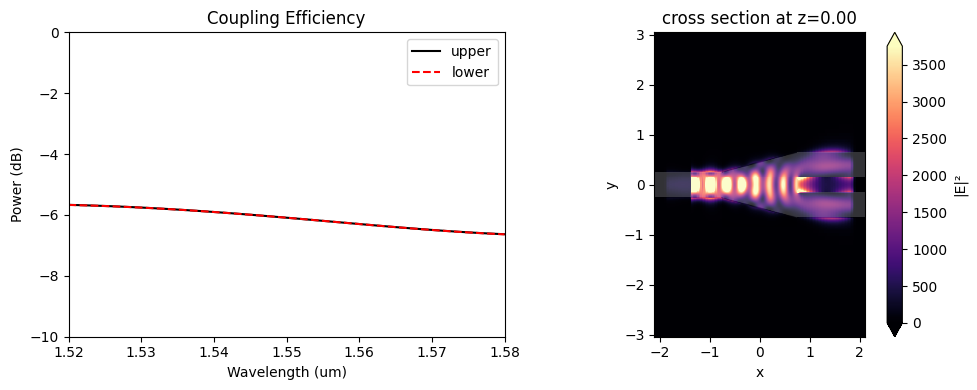

In [16]:
coeffs_f = sim_data["out_1"].amps.sel(direction="+")
power_1 = np.abs(coeffs_f.sel(mode_index=0)) ** 2
power_1_db = 10 * np.log10(power_1)

coeffs_f = sim_data["out_2"].amps.sel(direction="+")
power_2 = np.abs(coeffs_f.sel(mode_index=0)) ** 2
power_2_db = 10 * np.log10(power_2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
ax1.plot(wl_range, power_1_db, "-k", label="upper")
ax1.plot(wl_range, power_2_db, "--r", label="lower")
ax1.set_xlabel("Wavelength (um)")
ax1.set_ylabel("Power (dB)")
ax1.set_ylim(-10, 0)
ax1.legend()
ax1.set_xlim(wl - bw / 2, wl + bw / 2)
ax1.set_title("Coupling Efficiency")
sim_data.plot_field("field_xy", "E", "abs^2", z=0, ax=ax2)
plt.show()

## Running the Optimization

The figure-of-merit used in the y-branch optimization is the coupling efficiencies ($\eta_{1,2}$) of the incident power into the fundamental transverse electric mode of the output waveguides. As we are using a minimization strategy, the figure-of-merits are arranged within the objective function as $(0.5 - \eta_{1})^{2} + (0.5 - \eta_{2})^{2}$. This way, we enforce equal power flowing into the upper and lower output waveguides. However, this behavior can be changed if an inbalance is desired in the outputs. 

In [17]:
# Figure of Merit (FOM) calculation.
def fom(sim_data: tda.JaxSimulationData) -> float:
    """Return the power at the mode index of interest."""
    output_amps1 = sim_data.output_data[0].amps
    amp1 = output_amps1.sel(direction="+", f=freq, mode_index=0)

    output_amps2 = sim_data.output_data[1].amps
    amp2 = output_amps2.sel(direction="+", f=freq, mode_index=0)

    eta1 = jnp.sum(jnp.abs(amp1)) ** 2
    eta2 = jnp.sum(jnp.abs(amp2)) ** 2
    return (0.5 - eta1) ** 2 + (0.5 - eta2) ** 2


# Objective function to be passed to the optimization algorithm.
def obj(design_param, verbose: bool = False) -> float:
    sim = make_adjoint_sim(design_param)
    sim_data = run(sim, task_name="inv_des_ybranch", verbose=verbose)
    fom_val = fom(sim_data)
    return fom_val

# Function to calculate the objective function value and its
# gradient with respect to the design parameters.
obj_grad = value_and_grad(obj)

Optimizer initialization

In [18]:
# Initialize adam optimizer with starting parameters.
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(init_rho)

Now, we are ready to run the optimization!

In [19]:
# Store history
params = init_rho
obj_val = []
params_history = [init_rho]

for i in range(iterations):

    # Compute gradient and current objective funciton value.
    value, gradient = obj_grad(params)

    # outputs
    print(f"Step = {i + 1}")
    print(f"\tobj_val = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

    # Compute and apply updates to the optimizer based on gradient.
    updates, opt_state = optimizer.update(gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # Save history.
    obj_val.append(value)
    params_history.append(params)

# Gets the final parameters and the objective values history.
final_par = params_history[-1]
obj_vals = np.array(obj_val)

Step = 1
	obj_val = 1.2900e-01
	grad_norm = 8.9869e-02


[21:49:35] WARNING: No connection: Retrying for 180 seconds.        ]8;id=962112;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=43537;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#56\56]8;;\

Step = 2
	obj_val = 1.1827e-01
	grad_norm = 8.6319e-02
Step = 3
	obj_val = 1.0802e-01
	grad_norm = 8.1129e-02
Step = 4
	obj_val = 9.8646e-02
	grad_norm = 7.5000e-02
Step = 5
	obj_val = 8.9640e-02
	grad_norm = 6.8308e-02
Step = 6
	obj_val = 8.1293e-02
	grad_norm = 6.1541e-02
Step = 7
	obj_val = 7.3673e-02
	grad_norm = 5.5000e-02
Step = 8
	obj_val = 6.6834e-02
	grad_norm = 4.8889e-02
Step = 9
	obj_val = 6.0747e-02
	grad_norm = 4.3337e-02
Step = 10
	obj_val = 5.5325e-02
	grad_norm = 3.8404e-02
Step = 11
	obj_val = 5.0455e-02
	grad_norm = 3.4074e-02
Step = 12
	obj_val = 4.6012e-02
	grad_norm = 3.0294e-02
Step = 13
	obj_val = 4.1903e-02
	grad_norm = 2.7014e-02
Step = 14
	obj_val = 3.8118e-02
	grad_norm = 2.4181e-02
Step = 15
	obj_val = 3.4718e-02
	grad_norm = 2.1733e-02
Step = 16
	obj_val = 3.1724e-02
	grad_norm = 1.9606e-02
Step = 17
	obj_val = 2.9064e-02
	grad_norm = 1.7746e-02
Step = 18
	obj_val = 2.6653e-02
	grad_norm = 1.6110e-02
Step = 19
	obj_val = 2.4426e-02
	grad_norm = 1.4653e-02


### Optimization Results

After 50 iterations, the objective function converged to $4.55\times10^{-3}$.

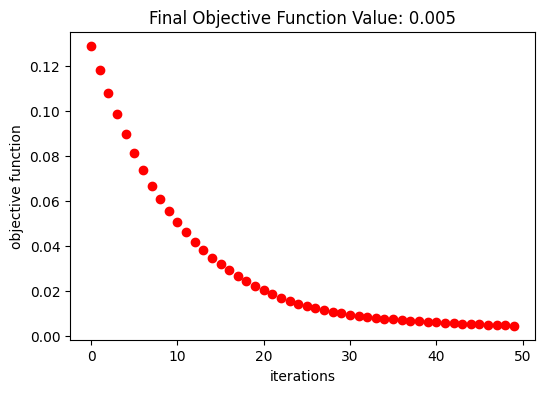

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(obj_vals, "ro")
ax.set_xlabel("iterations")
ax.set_ylabel("objective function")
ax.set_title(f"Final Objective Function Value: {obj_vals[-1]:.3f}")
plt.show()

A smooth and well-defined geometry was obtained after the optimization. 

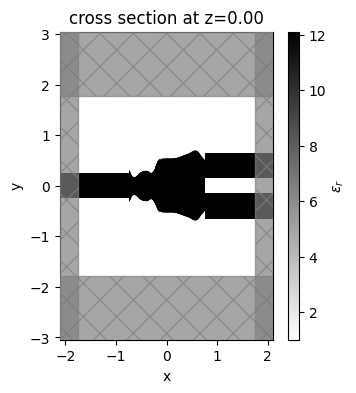

In [21]:
final_par = params_history[-1]
fig, ax = plt.subplots(1, figsize=(4, 4))
sim_final = make_adjoint_sim(final_par)
sim_final = sim_final.to_simulation()[0]
sim_final.plot_eps(z=0, source_alpha=0, monitor_alpha=0, ax=ax)
plt.show()

Once the inverse design is complete, we can visualize the field distributions and the wavelength dependent coupling efficiencies.

In [22]:
sim_final = sim_final.copy(update=dict(monitors=(field_xy, fom_final_1, fom_final_2)))
sim_data_final = web.run(sim_final, task_name="inv_des_final")

[22:54:26] Created task 'inv_des_final' with task_id               ]8;id=777117;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=345228;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-1bf67029-1702-4c9d-903d-fcc58e292d43v1'.                       

           View task using web UI at                               ]8;id=547665;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=705184;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=999177;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1bf67029-1702-4c9d-903d-fcc58e292d43v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=266737;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1bf67029-1702-4c9d-903d-fcc58e292d43v1\taskId]8;;\]8;id=999177;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1bf67029-1702-4c9d-903d-fcc58e292d43v1\=]8;;\]8;id=435295;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1bf67029-1702-4c9d-903d-fcc58e292d43v1\fdve]8;;\]8;id=999177;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1bf67029-1702-4c9d-903d-fcc58e292d43v1\-]8;;\              
           ]8;id=999177;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1bf67029-1702-4c9d-903d-fcc58e292d43v1\1bf67029-1702-4c9d-903d-fcc58e292d43v1']8;;\.                             

Output()

[22:54:30] status = queued                                         ]8;id=575624;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=638645;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#361\361]8;;\

Output()

[22:54:37] Maximum FlexCredit cost: 0.025. Use                     ]8;id=25773;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=944683;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=585062;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=392565;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#377\377]8;;\

           running solver                                          ]8;id=181157;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=53292;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=930451;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=371927;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[22:54:55] early shutoff detected, exiting.                        ]8;id=844728;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=285875;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#404\404]8;;\

           status = postprocess                                    ]8;id=985877;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=984668;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#420\420]8;;\

Output()

[22:55:07] status = success                                        ]8;id=489781;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=328406;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#427\427]8;;\

Output()

[22:55:11] loading SimulationData from simulation_data.hdf5        ]8;id=889802;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=343466;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#591\591]8;;\

The resulting structure shows good performance, presenting equal coupling efficiencies about -3.5 dB for both output waveguides. This result can be improved by reducing the gap between the output waveguides and increasing the number of iterations.

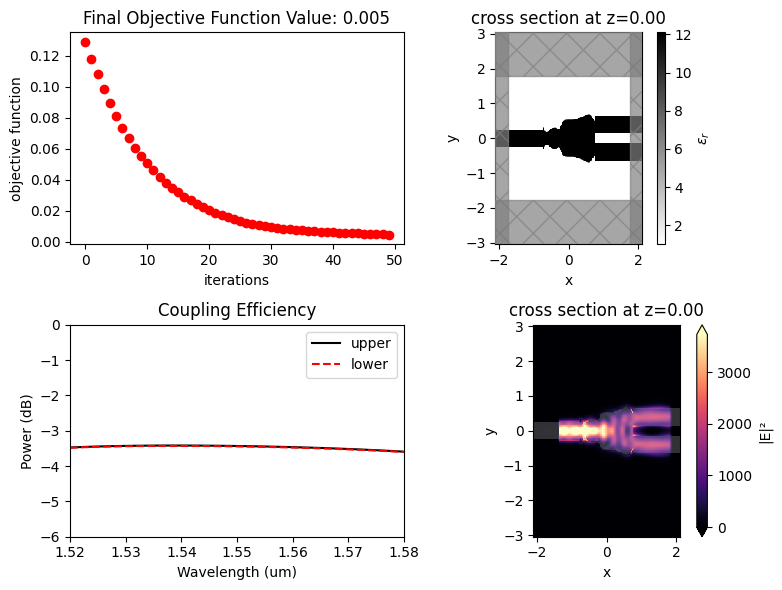

In [23]:
mode_amps = sim_data_final["out_1"]
coeffs_f = mode_amps.amps.sel(direction="+")
power_1 = np.abs(coeffs_f.sel(mode_index=0)) ** 2
power_1_db = 10 * np.log10(power_1)

mode_amps = sim_data_final["out_2"]
coeffs_f = mode_amps.amps.sel(direction="+")
power_2 = np.abs(coeffs_f.sel(mode_index=0)) ** 2
power_2_db = 10 * np.log10(power_2)

f, ax = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
sim_final.plot_eps(z=0, source_alpha=0, monitor_alpha=0, ax=ax[0, 1])
ax[1, 0].plot(wl_range, power_1_db, "-k", label="upper")
ax[1, 0].plot(wl_range, power_2_db, "--r", label="lower")
ax[1, 0].set_xlabel("Wavelength (um)")
ax[1, 0].set_ylabel("Power (dB)")
ax[1, 0].set_ylim(-6, 0)
ax[1, 0].legend()
ax[1, 0].set_xlim(wl - bw / 2, wl + bw / 2)
ax[1, 0].set_title("Coupling Efficiency")
sim_data_final.plot_field("field_xy", "E", "abs^2", z=0, ax=ax[1, 1])
ax[0, 0].plot(obj_vals, "ro")
ax[0, 0].set_xlabel("iterations")
ax[0, 0].set_ylabel("objective function")
ax[0, 0].set_title(f"Final Objective Function Value: {obj_vals[-1]:.3f}")
plt.show()